In [1]:
import pandas as pd
import numpy as np
import math
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from decimal import Decimal
from matplotlib.colors import BoundaryNorm

from statannotations.Annotator import Annotator

from scipy import stats
import statsmodels.stats.multitest
from decimal import Decimal

from sklearn import preprocessing

import pickle 
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')

import utils_statistics, utils_plotting, utils_misc

# 1. Data Loading

In [3]:
dystonia_genetics = pd.read_csv('dataset/genetic_dystonia_pallidal_neuron_activity.csv')
dystonia_genetics = dystonia_genetics[dystonia_genetics.patient!="patient1"] # removing benign-SGCE case

# fill np.nan values with 0
dystonia_genetics = dystonia_genetics.fillna(0)

# these two features can have infinite values due to 0 division problem. while their measurement
dystonia_genetics['pause_index'].replace(np.inf,dystonia_genetics.loc[dystonia_genetics['pause_index'] != np.inf, 'pause_index'].max(),inplace=True)
dystonia_genetics['pause_ratio'].replace(np.inf,dystonia_genetics.loc[dystonia_genetics['pause_ratio'] != np.inf, 'pause_ratio'].max(),inplace=True)

In [4]:
features = dystonia_genetics.columns.to_list()
features.remove('patient')
features.remove('hemisphere')
features.remove('trajectory')
features.remove('depth')
features.remove('spike_pattern')
features.remove('gene')

features_non_param = features.copy()
features_non_param.remove('is_bursting')
features_non_param.remove('is_tonic')
features_non_param.remove('is_irregular')
features_non_param.remove('delta_band_oscillatory')
features_non_param.remove('theta_band_oscillatory')
features_non_param.remove('alpha_band_oscillatory')
features_non_param.remove('beta_band_oscillatory')
features_non_param.remove('gamma_band_oscillatory')
features_non_param.remove('is_oscillatory')

feat_binary = list(np.setdiff1d(features,features_non_param))
data_AOPEP  = dystonia_genetics[dystonia_genetics.gene == "AOPEP"]
data_GNAL   = dystonia_genetics[dystonia_genetics.gene == "GNAL"]
data_KMT2B  = dystonia_genetics[dystonia_genetics.gene == "KMT2B"]
data_PANK2  = dystonia_genetics[dystonia_genetics.gene == "PANK2"]
data_PLA2G6 = dystonia_genetics[dystonia_genetics.gene == "PLA2G6"]
data_SGCE   = dystonia_genetics[dystonia_genetics.gene == "SGCE"]
data_THAP1  = dystonia_genetics[dystonia_genetics.gene == "THAP1"]
data_TOR1A  = dystonia_genetics[dystonia_genetics.gene == "TOR1A"]
data_VPS16  = dystonia_genetics[dystonia_genetics.gene == "VPS16"]

gene_data  = pd.DataFrame(columns=dystonia_genetics.columns)
gene_data  = pd.concat([data_AOPEP,data_GNAL,data_KMT2B,
                        data_PANK2,data_PLA2G6,data_SGCE,
                        data_THAP1,data_TOR1A,data_VPS16], ignore_index=True)

populations = [data_AOPEP, data_GNAL, data_KMT2B, data_PANK2, data_PLA2G6, data_SGCE, data_THAP1, data_TOR1A, data_VPS16]
N           = len(gene_data)
genes       = ["AOPEP","GNAL","KMT2B","PANK2","PLA2G6","SGCE","THAP1","TOR1A","VPS16"]

# 2. Statistical Comparisons

In [6]:
kw_results       = utils_statistics.nonparametric_population_test(gene_data, features_non_param)
mann_wu_results  = utils_statistics.nonparametric_postadhoc_test(populations, features_non_param, genes)
chi2_results     = utils_statistics.chi_square_test(gene_data, feat_binary)
fisher_e_results = utils_statistics.fisher_exact_test(gene_data, genes, feat_binary)

In [7]:
kw_results.to_csv("test_results/kruskall_wallis_test_results.csv", index=False)
mann_wu_results.to_csv("test_results/mann_whitney_u_results.csv", index=False)
chi2_results.to_csv("test_results/chi2_results.csv", index=False)
fisher_e_results.to_csv("test_results/fisher_e_results.csv", index=False)

# 3. PCA Analyses

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X        = dystonia_genetics[features]
X        = X.fillna(0)
X_scaled = StandardScaler().fit_transform(X)
X        = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
Y        = dystonia_genetics.gene

In [10]:
# Apply PCA
pca = PCA(n_components=5)
principal_components = pca.fit_transform(X)

data_pca = pd.DataFrame()
data_pca["PC1"]  = principal_components[:,0]
data_pca["PC2"]  = principal_components[:,1]
data_pca["PC3"]  = principal_components[:,2]
data_pca["gene"] = dystonia_genetics.gene.to_list()

feature_contributions = pca.components_.T * np.sqrt(pca.explained_variance_)
explained_variance    = pd.DataFrame()
explained_variance["component"] = ["PC1","PC2","PC3","PC4","PC5"]
explained_variance["score"]     = np.transpose(pca.explained_variance_ratio_)

pca_contributions = pd.DataFrame(feature_contributions, columns=['PC1', 'PC2', 'PC3',"PC4","PC5"], index=X.columns)
pca_contributions.abs()

# CH Scoring
genes_map         = {'AOPEP':1, 'GNAL'  :2, 'KMT2B':3, 'PANK2':4, 'PLA2G6':5, 'SGCE' :6, 'THAP1':7, 'TOR1A' :8, 'VPS16':9}
calinski_harabasz = utils_statistics.ch_score(X, Y, genes, genes_map)

In [11]:
explained_variance

,component,score
0,PC1,0.262174
1,PC2,0.124391
2,PC3,0.103092
3,PC4,0.059742
4,PC5,0.057394


# 4. Plotting

<Figure size 640x480 with 0 Axes>

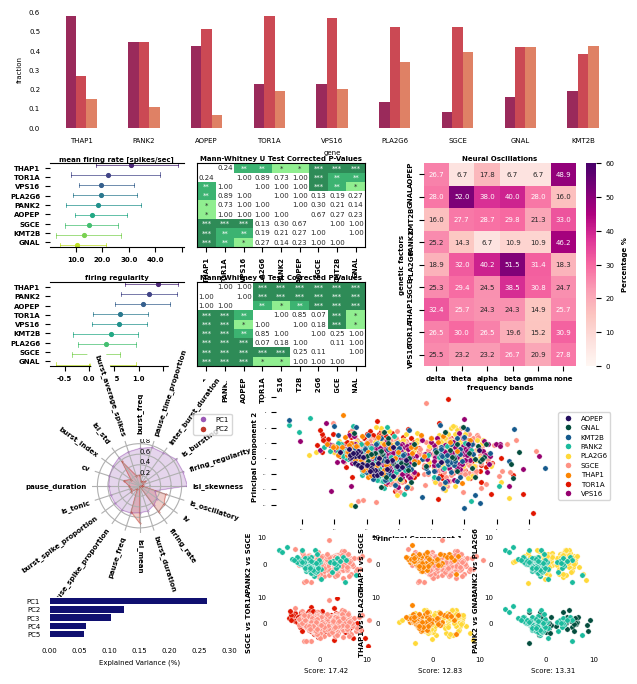

In [13]:
plt.rc('font', serif="Neue Haas Grotesk Text Pro")

labelsize = 5

fig = plt.figure()
fig.tight_layout()
cm = 1/2.54  # centimeters in inches
plt.subplots(figsize=(18.5*cm, 21*cm))

fpsize      = 8

ax_fp       = plt.subplot2grid((75, 50), (0, 0), colspan=50, rowspan=14)
ax_fr       = plt.subplot2grid((75, 50), (18, 0)   , colspan=12, rowspan=10)
ax_fr_dis   = plt.subplot2grid((75, 50), (18, 13)  , colspan=15, rowspan=10)
ax_reg      = plt.subplot2grid((75, 50), (32, 0)   , colspan=12, rowspan=10)
ax_reg_dis  = plt.subplot2grid((75, 50), (32, 13)  , colspan=15, rowspan=10)
ax_osc      = plt.subplot2grid((75, 50), (18, 33)  , colspan=19, rowspan=24)


fractions   = dystonia_genetics.groupby('gene')['spike_pattern'].value_counts(normalize=True).rename('fraction').reset_index()
ax_fp       = sns.barplot(x='gene', y='fraction', hue='spike_pattern', data=fractions, ax=ax_fp, width=0.5,
                          order = ['THAP1', 'PANK2', 'AOPEP', 'TOR1A', 'VPS16', 'PLA2G6', 'SGCE', 'GNAL', 'KMT2B'],
                          hue_order = ['tonic', 'irregular', 'bursting'], legend=False,
                          palette=["#ad1759ff", "#e13342ff","#f37651ff"])

utils_plotting.set_axis(ax_fp)

ax_fr      = utils_plotting.plot_biomarker_value_distribution(ax_fr, gene_data, genes=['THAP1','TOR1A','VPS16','PLA2G6','PANK2','AOPEP','SGCE','KMT2B','GNAL'], biomarker="firing_rate", biomarker_text="mean firing rate [spikes/sec]")
ax_fr_dis  = utils_plotting.plot_mwu_results(ax_fr_dis, mann_wu_results, genes=['THAP1','TOR1A','VPS16','PLA2G6','PANK2','AOPEP','SGCE','KMT2B','GNAL'], biomarker="firing_rate")
ax_reg     = utils_plotting.plot_biomarker_value_distribution(ax_reg, gene_data, genes=['THAP1','PANK2','AOPEP','TOR1A','VPS16','KMT2B','PLA2G6','SGCE','GNAL'], biomarker="firing_regularity", biomarker_text="firing regularity")
ax_reg_dis = utils_plotting.plot_mwu_results(ax_reg_dis, mann_wu_results, genes=['THAP1','PANK2','AOPEP','TOR1A','VPS16','KMT2B','PLA2G6','SGCE','GNAL'], biomarker="firing_regularity")


frequency_bands  = ["delta", "theta", "alpha", "beta", "gamma", "none"]
oscillations     = []
for gene in genes:
    oscillations.append(utils_misc.oscillatory_characteristics(gene_data, gene)) 
oscillations     = np.array(oscillations)

ax_osc = sns.heatmap(oscillations, annot=True, fmt=".1f", ax=ax_osc, vmin=0, vmax=60, cmap="RdPu", 
                     annot_kws={'size': labelsize})
ax_osc.set_xticks(ticks=[0.5,1.5,2.5,3.5,4.5,5.5], labels=frequency_bands, size=labelsize, fontweight="bold")
ax_osc.set_yticks(ticks=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5], labels=genes, size=labelsize, fontweight="bold")
ax_osc.figure.axes[-1].yaxis.label.set_size(labelsize)
ax_osc.set_title("Neural Oscillations", size=labelsize, fontweight="bold", pad=2)
ax_osc.set_xlabel("frequency bands", size=labelsize, fontweight="bold", labelpad=2)
ax_osc.set_ylabel("genetic factors", size=labelsize, fontweight="bold", labelpad=2)
cbar = ax_osc.collections[0].colorbar
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_label('Percentage %', labelpad=labelsize, fontweight="bold")

#################################################################################################################
#################################################################################################################

gene_colors           = {}
gene_colors["AOPEP"]  = "#240E5E"
gene_colors["GNAL"]   = "#044D3E"
gene_colors["KMT2B"]  = "#155A8D"
gene_colors["PANK2"]  = "#1BBB9D"
gene_colors["PLA2G6"] = "#FFD939" 
gene_colors["SGCE"]   = "#FE9284"
gene_colors["THAP1"]  = "#FC8502"
gene_colors["TOR1A"]  = "#E11500"
gene_colors["VPS16"]  = "#95006F"

ax_radar = plt.subplot2grid((75, 50), (50, 2)  , colspan=12, rowspan=12, projection='polar')
ax_pca_v = plt.subplot2grid((75, 50), (69, 0)  , colspan=16, rowspan=5)

ax_pca   = plt.subplot2grid((75, 50), (45, 20) , colspan=25, rowspan=15)
ax_pcam1 = plt.subplot2grid((75, 50), (62, 20) , colspan=9, rowspan=6)
ax_pcam2 = plt.subplot2grid((75, 50), (62, 30) , colspan=9, rowspan=6)
ax_pcam3 = plt.subplot2grid((75, 50), (62, 40) , colspan=9, rowspan=6)
ax_pcam4 = plt.subplot2grid((75, 50), (69, 20) , colspan=9, rowspan=6)
ax_pcam5 = plt.subplot2grid((75, 50), (69, 30) , colspan=9, rowspan=6)
ax_pcam6 = plt.subplot2grid((75, 50), (69, 40) , colspan=9, rowspan=6)

# PCA PROJECTIONS OF POINTS
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "TOR1A"] , x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["TOR1A"])
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "SGCE"]  , x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["SGCE"])
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "PLA2G6"], x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["PLA2G6"])
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "VPS16"] , x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["VPS16"])
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "PANK2"] , x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["PANK2"])
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "KMT2B"] , x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["KMT2B"])
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "THAP1"] , x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["THAP1"])
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "GNAL"]  , x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["GNAL"])
ax_pca = sns.scatterplot(data=data_pca[data_pca.gene == "AOPEP"] , x="PC1", y="PC2", ax=ax_pca, s=15, color=gene_colors["AOPEP"])


ax_pca.tick_params(axis='both', which='major', labelsize=0)
ax_pca.tick_params(axis='both', which='minor', labelsize=0)
ax_pca.set_xlabel("Principal Component 1", fontsize=labelsize, weight='bold')
ax_pca.set_ylabel("Principal Component 2", fontsize=labelsize, weight='bold')
ax_pca.spines['right'].set_visible(False)
ax_pca.spines['left'].set_visible(False)
ax_pca.spines['top'].set_visible(False)
ax_pca.spines['bottom'].set_visible(False)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=list(gene_colors.values())[i], markersize=5, label=list(gene_colors.keys())[i]) for i in range(9)]
ax_pca.legend(handles=legend_elements, fontsize=labelsize, loc="center right", bbox_to_anchor=(1.2,0.5))

ax_pca_v = sns.barplot(explained_variance, x="score", y="component", color="navy", ax=ax_pca_v)
ax_pca_v.set_xlim([0,0.3])
ax_pca_v.spines['right'].set_visible(False)
ax_pca_v.spines['left'].set_visible(False)
ax_pca_v.spines['top'].set_visible(False)
ax_pca_v.spines['bottom'].set_visible(False)
ax_pca_v.set_xlabel("Explained Variance (%)", fontsize=labelsize)
ax_pca_v.set_ylabel("", fontsize=0)
ax_pca_v.tick_params(axis='both', which='major', labelsize=labelsize)
ax_pca_v.tick_params(axis='both', which='minor', labelsize=labelsize)

# PCA CONTRIBUTIONS
pca_contributions = pca_contributions.abs()
pca_contributions = pca_contributions[["PC1","PC2"]]
pca_contributions = pca_contributions[(pca_contributions.PC1>0.5) | (pca_contributions.PC2>0.5)]
pca_contributions = pca_contributions.sort_values("PC1", ascending=False)
utils_plotting.radar_chart(pca_contributions, ax_radar)

legend_elements  = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=["#9B59B6","#C0392B"][i], markersize=5, label=["PC1","PC2"][i]) for i in range(2)]
ax_radar.legend(handles=legend_elements, fontsize=labelsize, loc="upper right", bbox_to_anchor=(1.45, 1.25))

# PCA PAIR-MATCH
utils_plotting.plot_PCA(data_pca, gene1="PANK2" , gene2="SGCE"  , axis=ax_pcam1 , colors=gene_colors, score=calinski_harabasz.loc["PANK2","SGCE"])
utils_plotting.plot_PCA(data_pca, gene1="THAP1" , gene2="SGCE"  , axis=ax_pcam2 , colors=gene_colors, score=calinski_harabasz.loc["SGCE","THAP1"])
utils_plotting.plot_PCA(data_pca, gene1="PANK2" , gene2="PLA2G6", axis=ax_pcam3 , colors=gene_colors, score=calinski_harabasz.loc["PANK2","PLA2G6"])
utils_plotting.plot_PCA(data_pca, gene1="SGCE"  , gene2="TOR1A" , axis=ax_pcam4 , colors=gene_colors, score=calinski_harabasz.loc["SGCE","TOR1A"])
utils_plotting.plot_PCA(data_pca, gene1="THAP1" , gene2="PLA2G6", axis=ax_pcam5 , colors=gene_colors, score=calinski_harabasz.loc["PLA2G6","THAP1"])
utils_plotting.plot_PCA(data_pca, gene1="PANK2" , gene2="GNAL"  , axis=ax_pcam6 , colors=gene_colors, score=calinski_harabasz.loc["GNAL","PANK2"])

utils_plotting.set_axis(ax_pca_v)
utils_plotting.set_axis(ax_pcam1)
utils_plotting.set_axis(ax_pcam2)
utils_plotting.set_axis(ax_pcam3)
utils_plotting.set_axis(ax_pcam4)
utils_plotting.set_axis(ax_pcam5)
utils_plotting.set_axis(ax_pcam6)

plt.savefig("figures/Figure 1.svg", dpi=300)

In [14]:
calinski_harabasz

,AOPEP,GNAL,KMT2B,PANK2,PLA2G6,SGCE,THAP1,TOR1A,VPS16
AOPEP,0.000000,10.320075,7.617714,0.850815,9.502183,11.632090,3.099700,4.316765,4.269407
GNAL,10.320075,0.000000,1.665145,13.308140,2.349795,2.101202,11.978304,7.307341,7.167078
KMT2B,7.617714,1.665145,0.000000,11.916652,2.768418,2.546633,11.102538,6.913884,6.964669
PANK2,0.850815,13.308140,11.916652,0.000000,17.632476,25.122469,2.867190,9.312192,9.345076
PLA2G6,9.502183,2.349795,2.768418,17.632476,0.000000,3.124140,12.825806,9.671555,7.517280
SGCE,11.632090,2.101202,2.546633,25.122469,3.124140,0.000000,19.542761,17.418381,12.961931
THAP1,3.099700,11.978304,11.102538,2.867190,12.825806,19.542761,0.000000,7.966659,8.463301
TOR1A,4.316765,7.307341,6.913884,9.312192,9.671555,17.418381,7.966659,0.000000,1.761164
VPS16,4.269407,7.167078,6.964669,9.345076,7.517280,12.961931,8.463301,1.761164,0.000000
